In [2]:
import gzip
import zipfile

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from owid.catalog import Table
from shapely.geometry import mapping
from structlog import get_logger
from tqdm import tqdm

from etl.helpers import PathFinder, create_dataset

# Initialize logger.
log = get_logger()

In [3]:
    snap_path = '/Users/veronikasamborska/etl/data/snapshots/climate/2023-12-20/surface_temperature.gz'
    # Load data from snapshot.
    with gzip.open(snap_path, "r") as _file:
        ds = xr.open_dataset(_file)

    # The latest 3 months in this dataset are made available through ERA5T, which is slightly different to ERA5. In the downloaded file, an extra dimenions ‘expver’ indicates which data is ERA5 (expver = 1) and which is ERA5T (expver = 5).
    # If a value is missing in the first dataset, it is filled with the value from the second dataset.
    ERA5_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))

    # Select the 't2m' variable from the combined dataset and assign it to 'da'.
    da = ERA5_combine["t2m"]

    # Convert the temperature values from Kelvin to Celsius by subtracting 273.15.
    da = da - 273.15


    # Construct the correct path for Geopandas
    file_path = 'zip:///Users/veronikasamborska/etl/data/snapshots/countries/2023-12-27/world_bank.zip!/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp'

    # Read the shapefile directly from the ZIP archive
    shapefile = gpd.read_file(file_path)
    shapefile = shapefile[["geometry", "WB_NAME"]]


/Users/veronikasamborska/etl/.venv/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [33]:
shapefile[shapefile["WB_NAME"] == "Estonia"]

,geometry,WB_NAME
48,"MULTIPOLYGON (((24.30616 57.86819, 24.31666 57...",Estonia


In [34]:

# Initialize an empty dictionary to store the country-wise average temperature.
temp_country = {}

# Initialize a list to keep track of small countries where temperature data extraction fails.
small_countries = []

# Extract the data for the current row.
data = shapefile[shapefile.index == 48]

# Set the coordinate reference system for the temperature data to EPSG 4326.
da.rio.write_crs("epsg:4326", inplace=True)

# Clip the temperature data to the current country's shape.
clip = da.rio.clip(data.geometry.apply(mapping), data.crs)




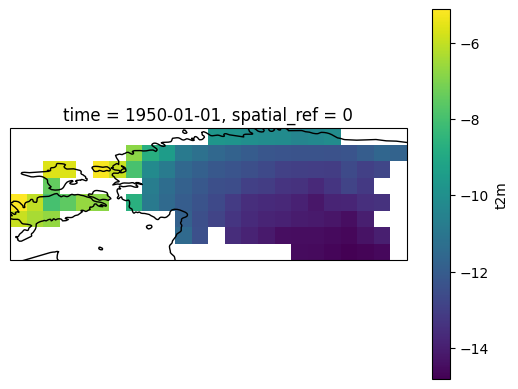

In [35]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# Select a single time step
single_time_step = clip.isel(time=0)

# Create a figure with a geographic projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()  # Add coastlines for context

# Plot data
single_time_step.plot(ax=ax, transform=ccrs.PlateCarree(), x='longitude', y='latitude', add_colorbar=True)

plt.show()

In [22]:

# Apply the weights to the clipped temperature data.
clim_month_weighted = clip.weighted(weights)

# Calculate the weighted mean temperature for the country.
country_weighted_mean = clim_month_weighted.mean(dim=["longitude", "latitude"]).values


In [29]:
weights

<xarray.DataArray 'weights' (latitude: 32)>
array([0.61221725, 0.6156615 , 0.61909395, 0.62251467, 0.62592345,
       0.6293204 , 0.63270533, 0.6360782 , 0.639439  , 0.6427876 ,
       0.646124  , 0.64944804, 0.65275973, 0.656059  , 0.6593458 ,
       0.66262007, 0.66588163, 0.66913056, 0.6723668 , 0.67559016,
       0.67880076, 0.6819983 , 0.685183  , 0.68835455, 0.691513  ,
       0.6946584 , 0.69779044, 0.70090926, 0.7040147 , 0.70710677,
       0.7101854 , 0.71325046], dtype=float32)
Coordinates:
  * latitude     (latitude) float32 52.25 52.0 51.75 51.5 ... 45.0 44.75 44.5
    spatial_ref  int64 0
Attributes:
    units:          degrees_north
    long_name:      latitude
    axis:           Y
    standard_name:  latitude